# `qp` Demo

_Alex Malz, Phil Marshall * Eric Charles_

In this notebook we use the `qp` module to approximate some simple, standard, 1-D PDFs using sets of quantiles, samples, and histograms, and assess their relative accuracy. We also show how such analyses can be extended to use "composite" PDFs made up of mixtures of standard distributions.

### Requirements

To run `qp`, you will need to first install the module. 

In [1]:
import numpy as np
import os
import scipy.stats as sps
import scipy.interpolate as spi

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline

import qp

## Background, the scipy.stats module

The scipy.stats module is the standard for manipulating distribtions.  It allows you do define a wide variety of distibutions and uses numpy array broadcasting for efficiency, here are some examples of things you can do with the scipy.stats module, using a Gaussian or normal distribution.

Note the distinction passing arguments to `norm` and passing arguments to `pdf`.

In [22]:
# evaluate the PDF at one point for one distribution
print("PDF at one point for one distribution:", sps.norm(loc=0, scale=1).pdf(0.5))
# evaluate the PDF at multiple points for one distribution
print("PDF at three points for one distribution:", sps.norm(loc=0, scale=1).pdf([0.5, 1., 1.5]))
# evalute the PDF one point from three distributions
print("PDF at one point for three distributions:", sps.norm(loc=[0., 1., 2.], scale=1).pdf(0.5))
# evalute the PDF at one different point of each of three distributions
print("PDF at one differnt point for three distributions:", sps.norm(loc=[0., 1., 2.], scale=1).pdf([0.5, 1., 1.5]))
# evalute the PDF at four differents point of each of three distributions (note the change in shape of the argument)
print("PDF at four differnt points for three distributions:\n",
      sps.norm(loc=[0., 1., 2.], scale=1).pdf([[0.5],[1.],[1.5],[2]]))
# evalute the PDF at four differents point of each of three distributions (note the change in shape of the argument)
print("PDF at four differnt points for three distributions: broadcast reversed\n",
      sps.norm(loc=[[0.], [1.], [2.]], scale=1).pdf([0.5,1.,1.5,2]))


PDF at one point for one distribution: 0.3520653267642995
PDF at three points for one distribution: [0.35206533 0.24197072 0.1295176 ]
PDF at one point for three distributions: [0.35206533 0.35206533 0.1295176 ]
PDF at one differnt point for three distributions: [0.35206533 0.39894228 0.35206533]
PDF at four differnt points for three distributions:
 [[0.35206533 0.35206533 0.1295176 ]
 [0.24197072 0.39894228 0.24197072]
 [0.1295176  0.35206533 0.35206533]
 [0.05399097 0.24197072 0.39894228]]
PDF at four differnt points for three distributions: broadcast reversed
 [[0.35206533 0.24197072 0.1295176  0.05399097]
 [0.35206533 0.39894228 0.35206533 0.24197072]
 [0.1295176  0.24197072 0.35206533 0.39894228]]


## Looking at the scipy.stats classes

In the scipy.stats module, all of the distributions are sub-classes of stats.rv_continuous.  You make an object of a particular sub-type, and then 'freeze' it by passing it shape parameters

In [3]:
print("This is the generic distribution class: ", sps._continuous_distns.norm_gen)
ng = sps._continuous_distns.norm_gen()
print("This is an instance of the generic distribution class", ng)
norm_sp = ng(loc=0, scale=1)
print("This is a frozen distribution, with specific paramters", norm_sp, norm_sp.kwds)
print("The frozen object know what distribution it comes from", norm_sp.dist)

This is the generic distribution class:  <class 'scipy.stats._continuous_distns.norm_gen'>
This is an instance of the generic distribution class <scipy.stats._continuous_distns.norm_gen object at 0x7fbe42a2f110>
This is a frozen distribution, with specific paramters <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fbe42a2f710> {'loc': 0, 'scale': 1}
The frozen object know what distribution it comes from <scipy.stats._continuous_distns.norm_gen object at 0x7fbe42a2f910>


## Properties of distribtuions

`scipy.stats` lets you use a evaluate of properties of distributions

In [4]:
print("PDF = ", norm_sp.pdf(0.5))
print("CDF = ", norm_sp.cdf(0.5))
print("PPF = ", norm_sp.ppf(0.5))
print("ISF = ", norm_sp.sf(0.5))
print("SF = ", norm_sp.sf(0.5))
print("RVS = ", norm_sp.rvs())

PDF =  0.3520653267642995
CDF =  0.6914624612740131
PPF =  0.0
ISF =  0.3085375387259869
SF =  0.3085375387259869
RVS =  0.9181955855956923


# Extending `scipy.stats` to implement the distributions that we want to use

The next part of this notebook shows how we can extend the functionality of `scipy.stats` to implement distributions that are based on objects like histograms or interpolations or splines or mixture models.

## qp normal distribution

This is a trivial extension, I've just added the number of pdfs as a member of the `scipy.stats.norm_gen` distribution.

loc and scale are the means and stdevs of the underlying Gaussians

In [5]:
loc = np.array([[0],[1]])
scale = np.array([[1],[1]])
norm_pdf = qp.norm(loc=loc, scale=scale)
xvals = np.linspace(-5, 5, 51)
yvals = norm_pdf.pdf(xvals)
print("This object represents %i pdfs" % norm_pdf.npdf)
print("The input and output shapes are:", xvals.shape, yvals.shape)

This object represents 2 pdfs
The input and output shapes are: (51,) (2, 51)


If you have a single distribution you can plot it, the `qp.qp_plot_native` function will find a nice way to represent the data used to construct the distribution.

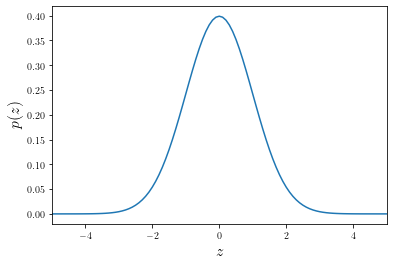

In [6]:
loc1 = np.array([[0]])
scale1 = np.array([[1]])
norm_pdf1 = qp.norm(loc=loc1, scale=scale1)
fig, axes = qp.qp_plot_native(norm_pdf1, xlim=(-5., 5.))

## qp histogram distribution

This represents a set of distributions made by interpolating a set of histograms with shared binning.
To construct this you need to give the bin edges (shape=(N)) and the bin values (shape=(npdf, N-1)).

Note that the native visual representation is different.

The input and output shapes are: (51, 1) (51, 2)


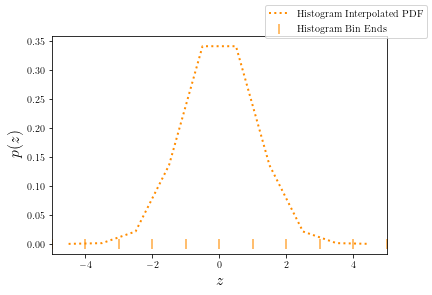

In [7]:
bins = np.linspace(-5, 5, 11)
cdf = norm_pdf.cdf(bins)
bin_vals = cdf[:,1:] - cdf[:,0:-1]
hist_pdf = qp.hist(bins=bins, pdfs=bin_vals)
xvals = np.expand_dims(xvals, -1)
yvals = hist_pdf.pdf(xvals)
print("The input and output shapes are:", xvals.shape, yvals.shape)
hist_pdf1 = qp.hist(bins=bins, pdfs=np.atleast_2d(bin_vals[0]))
fig, axes = qp.qp_plot_native(hist_pdf1, xlim=(-5., 5.))
leg = fig.legend()

## qp interpolated 

This represents a set of distributions made by interpolating a set of x and y values. To construct this you need to give the x and y values (both of shape=(npdf, N))

Note that the native visual representation is pretty similar to the original one for the Gaussian.

The input and output shapes are: (11,) (11, 2)


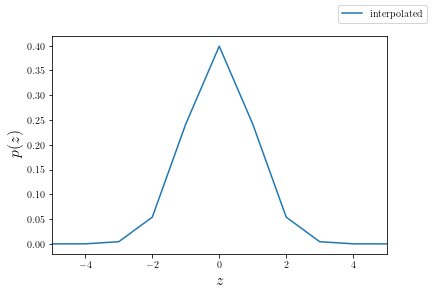

In [8]:
xvals = np.linspace(-5, 5, 11)
yvals = norm_pdf.pdf(xvals)
interp_pdf = qp.interp_fixed(xvals=xvals, yvals=yvals)
interp_vals = interp_pdf.pdf(np.expand_dims(xvals, -1))
print("The input and output shapes are:", xvals.shape, interp_vals.shape)
interp_pdf1 = qp.interp(xvals=np.atleast_2d(xvals), yvals=np.atleast_2d(yvals[0]))
fig, axes = qp.qp_plot_native(interp_pdf1, xlim=(-5., 5.), label="interpolated")
leg = fig.legend()

## qp spline distribution

This represents a set of distributions made building a set of splines. To construct this you can give the x and y values(both of shape=(npdf, N))

Note that the native visual representation is pretty similar to the original one for the Gaussian.

Note also that the spline knots are stored.

The input and output shapes are: (11,) (11, 2)
Spline knots [[-5. -5. -5. -5. -3. -2. -1.  0.  1.  2.  3.  5.  5.  5.  5.]
 [-5. -5. -5. -5. -3. -2. -1.  0.  1.  2.  3.  5.  5.  5.  5.]] [[ 1.48609459e-06  1.68880388e-03 -5.05824770e-03  2.11574348e-02
   2.37684221e-01  4.79319775e-01  2.37684221e-01  2.11574348e-02
  -5.05824770e-03  1.68880388e-03  1.48609459e-06  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 6.06104412e-09  2.92238254e-04 -6.45298875e-04  1.37859552e-03
   2.11510920e-02  2.37171684e-01  4.78440824e-01  2.36872840e-01
  -4.91623210e-02  1.99250573e-02  1.33503381e-04  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]] [[3]
 [3]]
(1, 15)


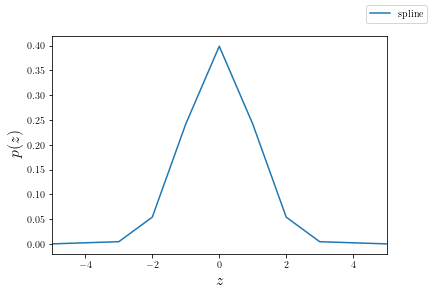

In [17]:
spline_pdf = qp.spline_from_xy(xvals=np.ones((2,11))*xvals, yvals=yvals)
spline_vals = spline_pdf.pdf(np.expand_dims(xvals, -1))
print("The input and output shapes are:", xvals.shape, spline_vals.shape)
print("Spline knots", spline_pdf.dist.splx, spline_pdf.dist.sply, spline_pdf.dist.spln)
spline_pdf1 = qp.spline_from_xy(xvals=np.atleast_2d(xvals), yvals=np.atleast_2d(yvals[0]))
print(spline_pdf1.dist.splx.shape)
fig, axes = qp.qp_plot_native(spline_pdf1, xlim=(-5., 5.), label="spline")
leg = fig.legend()

## qp quantile distribution

This represents a set of distributions made by interpolating the locations at which various distributions reach a given set of quantiles.
To construct this you need to give the quantiles edges (shape=(N)) and the location values (shape=(npdf, N)).

Note that the native visual representation is different.

The input and output shapes are: (11,) (11, 2)


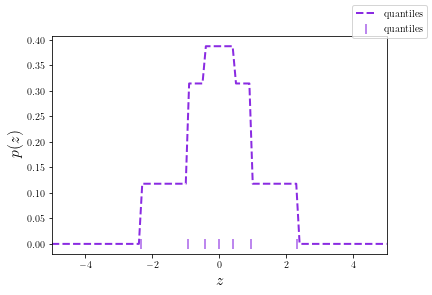

In [18]:
quants = np.linspace(0.01, 0.99, 7)
locs = norm_pdf.ppf(quants)
quant_pdf = qp.quant(quants=quants, locs=locs)
quant_vals = quant_pdf.pdf(np.expand_dims(xvals, -1))
print("The input and output shapes are:", xvals.shape, quant_vals.shape)
quant_pdf1 = qp.quant(quants=np.atleast_1d(quants), locs=np.atleast_2d(locs[0]))
fig, axes = qp.qp_plot_native(quant_pdf1, xlim=(-5., 5.), label="quantiles")
leg = fig.legend()

## kernal density estimate 

This represents a set of distributions made by producing a kernal density estimate from a set of samples.

To construct this you need to give the samples edges (shape=(npdf, N)).

Note again that the the native visual represenation is different.

/Users/echarles/software/vro/qp/qp/utils.py:115: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return quad(spline, limits[0], limits[1], **kwargs)[0]


The input and output shapes are: (11,) (51, 2)


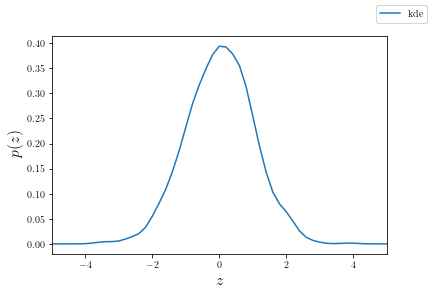

In [19]:
samples = norm_pdf.rvs(size=(2, 1000))
xvals_kde = np.linspace(-5., 5., 51)
kde_pdf = qp.spline_from_samples(xvals=xvals_kde, samples=samples)
kde_vals = kde_pdf.pdf(np.expand_dims(xvals_kde, -1))
print("The input and output shapes are:", xvals.shape, kde_vals.shape)
kde_pdf1 = qp.spline_from_samples(xvals=xvals_kde, samples=np.atleast_2d(samples[0]))
fig, axes = qp.qp_plot_native(kde_pdf1, xlim=(-5., 5.), label="kde")
leg = fig.legend()

## Overplotting

You can visually compare the represenations by plotting them all on the same figure.

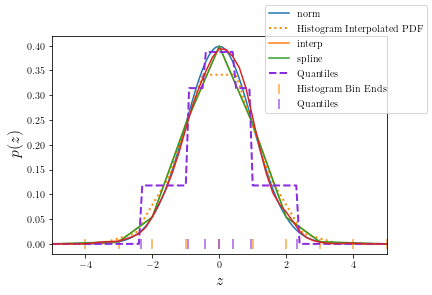

In [20]:
fig, axes = qp.qp_plot_native(norm_pdf1, xlim=(-5., 5.), label="norm")
qp.qp_plot_native(hist_pdf1, axes=axes)
qp.qp_plot_native(interp_pdf1, axes=axes, label="interp")
qp.qp_plot_native(spline_pdf1, axes=axes, label="spline")
qp.qp_plot_native(quant_pdf1, axes=axes)
qp.qp_plot_native(kde_pdf1, axes=axes)
leg = fig.legend()

## The `qp.Ensemble` Class

This is the basic element of `qp` - an object representing a set of probability density functions. This class is stored in the module `ensemble.py`.  

To create a `qp.Ensemble` you need to specify the class used to represent the PDFs, and provide that data for the specific set of PDFs.  Here we will great a 100 Gaussians with means distributed between -1 and 1, and widths distributed between 0.9 and 1.1.

In [21]:
locs = 2* (np.random.uniform(size=(100,1))-0.5)
scales = 1 + 0.2*(np.random.uniform(size=(100,1))-0.5)
ens_n = qp.Ensemble(qp.norm, data=dict(loc=locs, scale=scales))

## Using the ensemble

All of the functions distribution functions, `pdf`, `cdf` etc... work as with underlying classes. 

Just can use the square brackets operator `[]` to isolate a single member of the ensemble.  

The shapes are:  (11,) (100, 11)


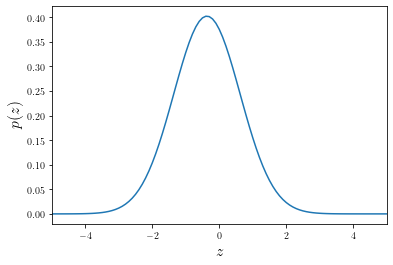

In [22]:
vals_n = ens_n.pdf(xvals)
print("The shapes are: ", xvals.shape, vals_n.shape)
fig, axes = qp.qp_plot_native(ens_n[15], xlim=(-5.,5.))

## Converting the ensemble

The `qp.qp_convert` function lets you convert ensembles to other representations. To do this you have to provide the original ensemble, the class you want to convert to, and any some keyword arguments to specify details about how to convert to the new class, here are some examples.

In [23]:
bins = np.linspace(-5, 5, 11)
quants = np.linspace(0.01, 0.99, 7)
print("Making hist")
ens_h = ens_n.convert_to(qp.hist_rows_gen, bins=bins)
print("Making interp")
ens_i = ens_n.convert_to(qp.interp_fixed_grid_rows_gen, xvals=bins)
print("Making spline")
ens_s = ens_n.convert_to(qp.spline_rows_gen, xvals=bins)
print("Making quants")
ens_q = ens_n.convert_to(qp.quant_rows_gen, quants=quants)
print("Making mixmod")
ens_m = ens_n.convert_to(qp.mixmod_rows_gen, samples=1000, ncomps=3)
print("Making flexcode")
ens_f = ens_n.convert_to(qp.flex_rows_gen, grid=bins, basis_system='cosine')

Making hist
Making interp
Making spline
Making quants
Making mixmod
Making flexcode


### Qualitative Comparisons: Plotting

Let's visualize the PDF object in order to original and the other representaions.  The solid, black line shows the true PDF evaluated between the bounds.  The green rugplot shows the locations of the 1000 samples we took.  The vertical, dotted, blue lines show the percentiles we asked for, and the hotizontal, dotted, red lines show the 10 equally spaced bins we asked for.  Note that the quantiles refer to the probability distribution *between the bounds*, because we are not able to integrate numerically over an infinite range. Interpolations of each parametrization are given as dashed lines in their corresponding colors.  Note that the interpolations of the quantile and histogram parametrizations are so close to each other that the difference is almost imperceptible!

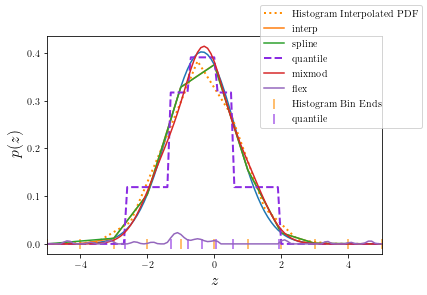

In [24]:
fig, axes = qp.qp_plot_native(ens_n[15], xlim=(-5.,5.))
qp.qp_plot_native(ens_h[15], axes=axes)
qp.qp_plot_native(ens_i[15], axes=axes, label='interp')
qp.qp_plot_native(ens_s[15], axes=axes, label='spline')
qp.qp_plot_native(ens_q[15], axes=axes, label='quantile')
qp.qp_plot_native(ens_m[15], axes=axes, label='mixmod')
qp.qp_plot_native(ens_f[15], axes=axes, label='flex')
leg = fig.legend()


We can also interpolate the function onto an evenly spaced grid point and cache those values with the `gridded` function.

In [25]:
grid = np.linspace(-3., 3., 100)
gridded = ens_n.pdf(grid)

In [26]:
cached_gridded = ens_n.gridded(grid)[1]
check = gridded - cached_gridded
print(check.min(), check.max())

0.0 0.0


## Comparing Parametrizations

`qp` supports quantitative comparisons between different distributions, across parametrizations.

### Quantitative Comparisons

In [27]:
symm_lims = np.array([-1., 1.])
all_lims = [symm_lims, 2.*symm_lims, 3.*symm_lims]

Next, let's compare the different parametrizations to the truth using the Kullback-Leibler Divergence (KLD).  The KLD is a measure of how close two probability distributions are to one another -- a smaller value indicates closer agreement.  It is measured in units of bits of information, the information lost in going from the second distribution to the first distribution.  The KLD calculator here takes in a shared grid upon which to evaluate the true distribution and the interpolated approximation of that distribution and returns the KLD of the approximation relative to the truth, which is not in general the same as the KLD of the truth relative to the approximation.  Below, we'll calculate the KLD of the approximation relative to the truth over different ranges, showing that it increases as it includes areas where the true distribution and interpolated distributions diverge.

In [28]:
# for a single pair of pdfs. (the 15th in each ensemble)
klds = ens_n.kld(ens_s, limits=all_lims[0])[15]
print(klds)

ValueError: operands could not be broadcast together with shapes (100,) (200,) 

In [29]:
# Loop over all the other ensemble types
ensembles = [ens_n, ens_h, ens_i, ens_s, ens_q, ens_m]
for ensemble in ensembles[1:]:
    D = []
    for lims in all_lims:
        klds = ens_n.kld(ensemble, limits=lims)
        D.append("%.2e +- %.2e" % (klds.mean(), klds.std()))
    print(ensemble.gen_class.name + ' approximation: KLD over 1, 2, 3, sigma ranges = ' + str(D))

ValueError: operands could not be broadcast together with shapes (100,) (200,) 

The progression of KLD values should follow that of the root mean square error (RMSE), another measure of how close two functions are to one another.  The RMSE also increases as it includes areas where the true distribution and interpolated distribution diverge.  Unlike the KLD, the RMSE is symmetric, meaning the distance measured is not that of one distribution from the other but of the symmetric distance between them.

In [ ]:
for ensemble in ensembles[1:]:
    D = []
    for lims in all_lims:
        rmses = ens_n.rmse(ensemble, limits=lims)
        D.append("%.2e +- %.2e" % (rmses.mean(), rmses.std()))
    print(ensemble.gen_class.name + ' approximation: RMSE over 1, 2, 3, sigma ranges = ' + str(D))

Both the KLD and RMSE metrics suggest that the quantile approximation is better in the high density region, but samples work better when the tails are included. We might expect the answer to the question of which approximation to use to depend on the application, and whether the tails need to be captured or not.

## Storing and retreiving ensembles

You can store and retrieve ensembles from disk, using the `qp.Ensemble.write_to` and `qp.Ensemble.read_from` methods.

These work in two steps, first the convert the Ensemble data to `astropy.table` objects, then they write the tables.  This means you can store the data in any format support by `astropy`

In [ ]:
tabs = ens_n.build_tables()
print(tabs.keys())
print()
print("Meta Data")
print(tabs['meta'])
print()
print("Object Data")
print(tabs['data'])

Here is a loopback test showing that we get the same results before and after a write/read cycle.

In [ ]:
suffix_list = ['_n', '_h', '_i', '_s', '_q', '_m']
filetypes = ['fits', 'hdf5']
for ens, suffix in zip(ensembles, suffix_list):
    for ft in filetypes:

        outfile = "test%s.%s" % (suffix, ft)

        pdf_1 = ens.pdf(bins)        
        ens.write_to(outfile)
        ens_r = qp.Ensemble.read_from(outfile)
        pdf_2 = ens_r.pdf(bins)

        check = pdf_1 - pdf_2
        print(suffix, ft, check.min(), check.max())

        os.unlink(outfile)

Finally, we can compare the moments of each approximation and compare those to the moments of the true distribution.

In [ ]:
which_moments = range(3)
all_moments = []
for ens in ensembles:
    moments = []
    for n in which_moments:
        moms = qp.metrics.calculate_moment(ens, n, limits=(-3, 3))
        moments.append("%.2e +- %.2e" % (moms.mean(), moms.std()))
    all_moments.append(moments)
    
print('moments: '+str(which_moments))
for ens, mom in zip(ensembles, all_moments):
    print(ens.gen_class.name+': '+str(mom))